In [1]:
!pip install pytorch-lightning

  Using cached torchmetrics-1.3.2-py3-none-any.whl.metadata (19 kB)
   ---------------------------------------- 0.0/801.6 kB ? eta -:--:--
   ------- -------------------------------- 153.6/801.6 kB 4.6 MB/s eta 0:00:01
   --------------------------------------- 801.6/801.6 kB 10.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/841.5 kB ? eta -:--:--
   --------------------------------------- 841.5/841.5 kB 52.0 MB/s eta 0:00:00


In [5]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [9]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [10]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [11]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [33]:
# GAN

class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.002):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        
        #Random Noise
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        
    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        opt1, opt2 = self.optimizers()
        real_imgs, _ = batch
        
        # Sample Noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)
        
        # Train Generator: max log(D(G(z))) where z is random noise
        if opt1 :
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)
            
            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)
            
            g_loss = self.adversarial_loss(y_hat, y)
            
            log_dict = {"g_loss": g_loss}
            return {"loss" : g_loss, "progress_bar": log_dict, "log": log_dict}
        
        # Train Discriminator: max log(D(x)) + log (1-D(G(z))) where x is real images
        if opt2:
            
            # Check how well it labels as real
            y_hat_real = self.discriminator(real_imgs)
            
            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.as_type(real_imgs)
            
            real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            # Check how well it labels as fake
            y_hat_fake = self.discriminator(self(z).detach())
            
            y_fake = torch.zeros(real_imgs.size(0), 1)
            y_fake = y_fake.as_type(real_imgs)
            
            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            
            d_loss = (real_loss + fake_loss) / 2
            
            log_dict = {"g_loss": d_loss}
            return {"loss" : d_loss, "progress_bar": log_dict, "log": log_dict}
        
        
    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)        
        return [opt_g, opt_d], []
    
    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        
        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2,3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i,0, :, :], cmap='gray_r', interpolation='none'), 
            plt.title('generated data')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()
    
    def on_train_epoch_end(self):
        self.plot_imgs()

In [34]:
dm = MNISTDataModule()
model = GAN()

epoch 0


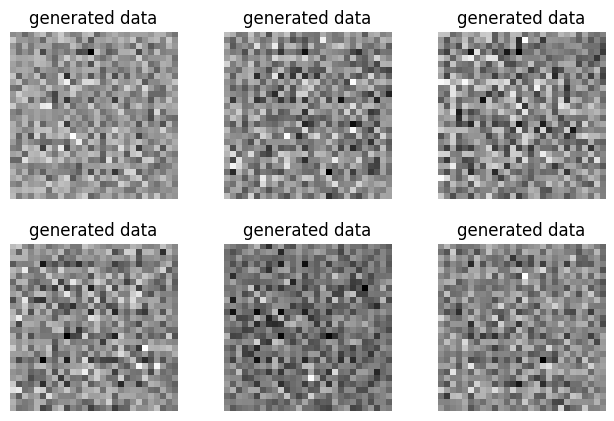

In [35]:
model.plot_imgs()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

epoch 0


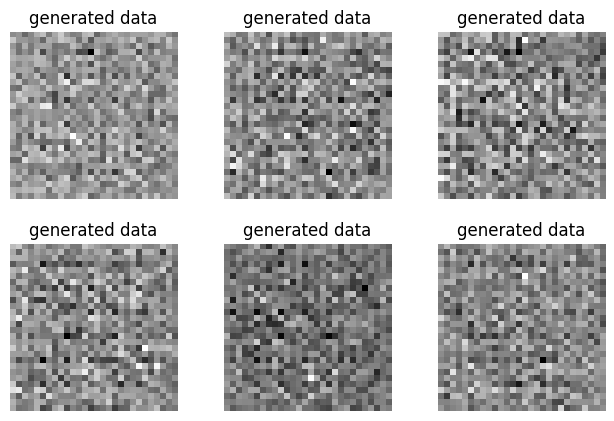

epoch 1


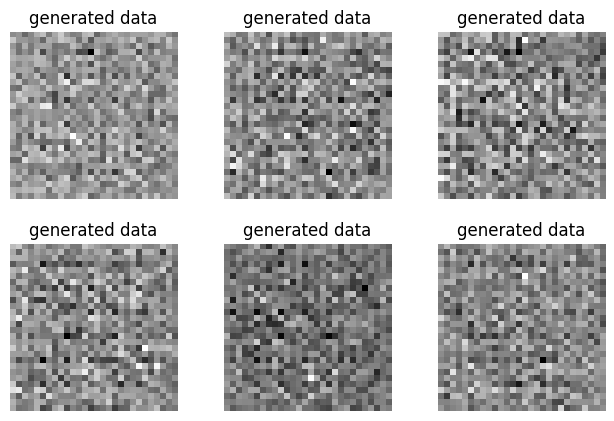

epoch 2


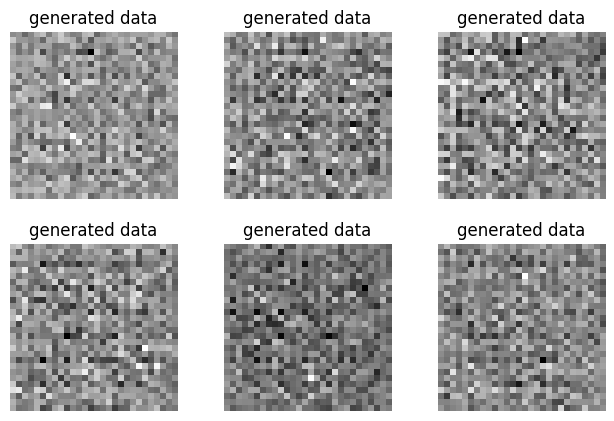

epoch 3


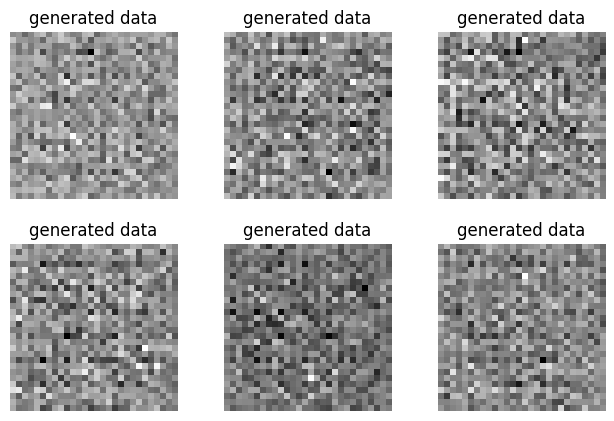

epoch 4


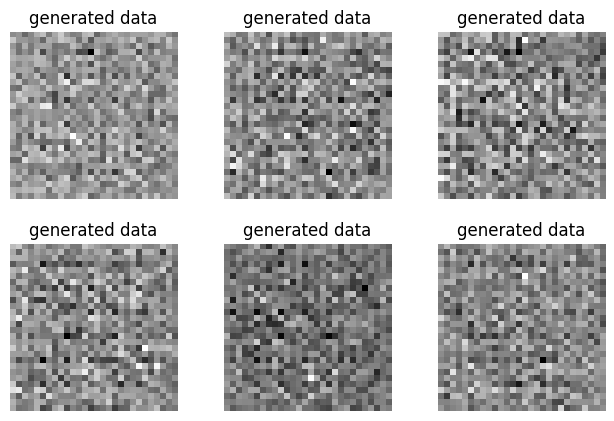

epoch 5


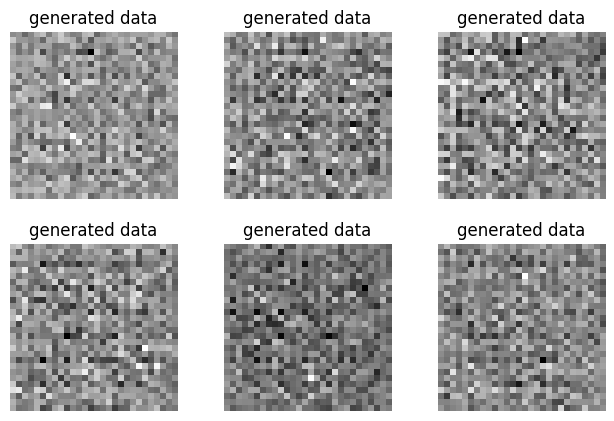

epoch 6


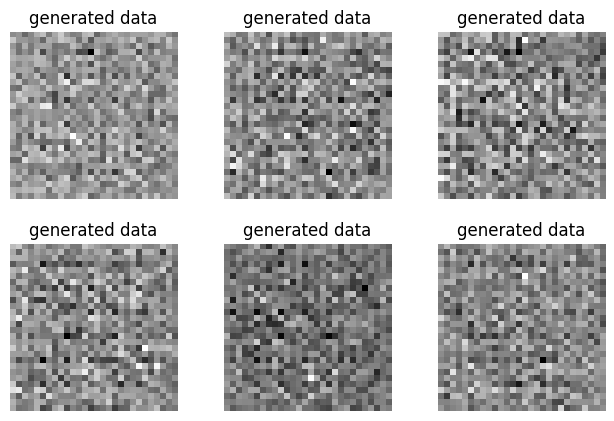

epoch 7


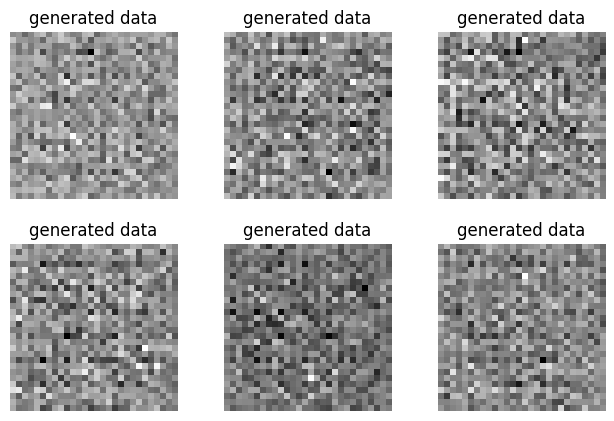

epoch 8


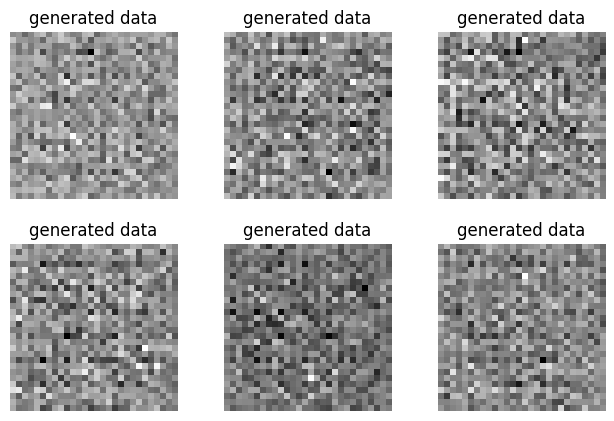

epoch 9


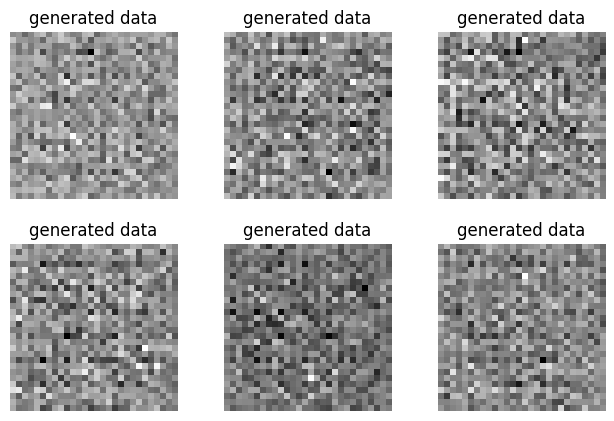

epoch 10


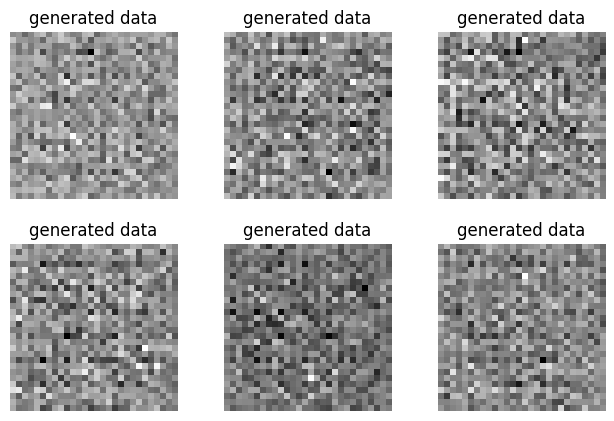

epoch 11


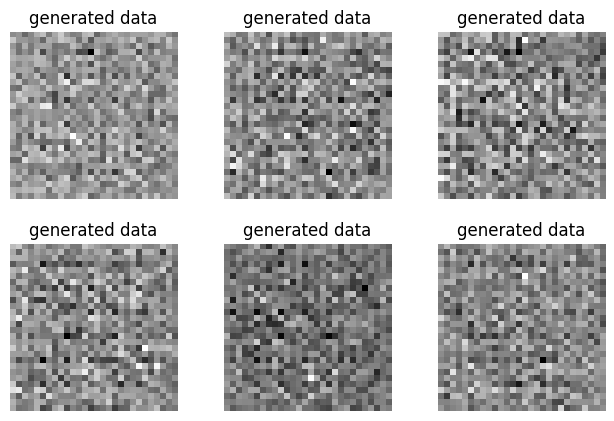

epoch 12


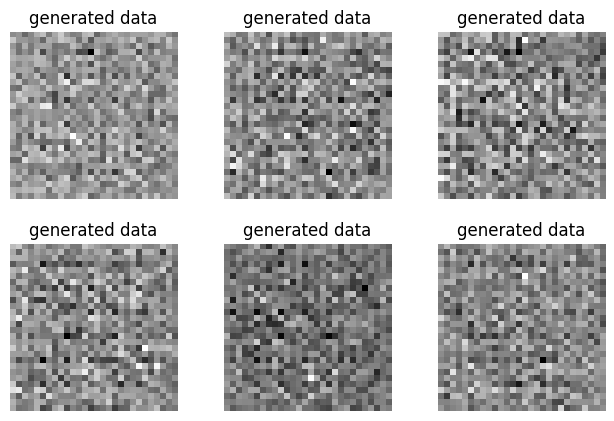

epoch 13


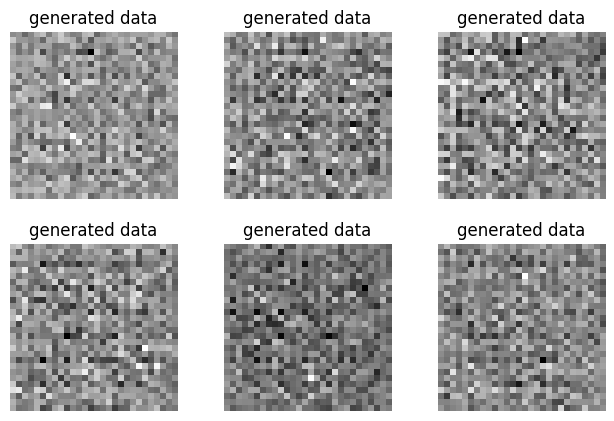

epoch 14


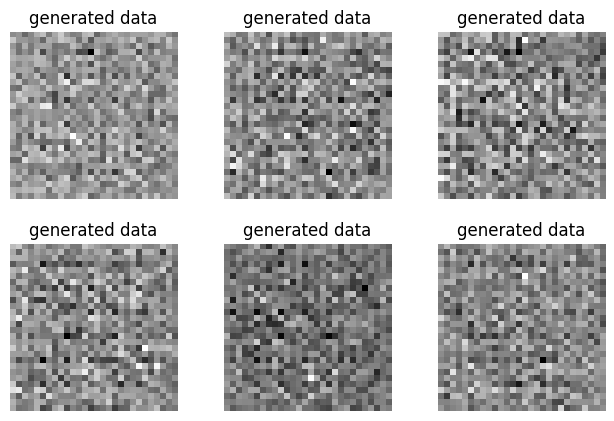

epoch 15


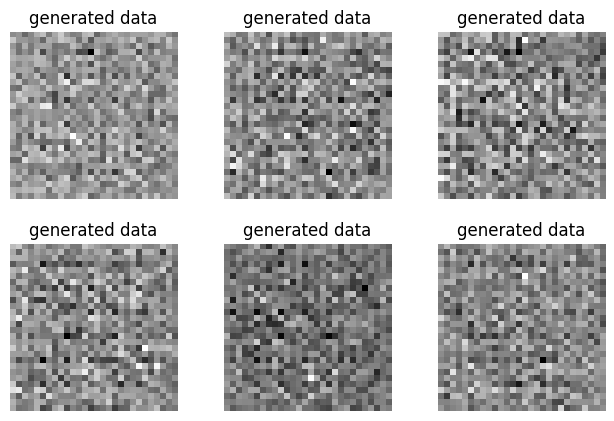

epoch 16


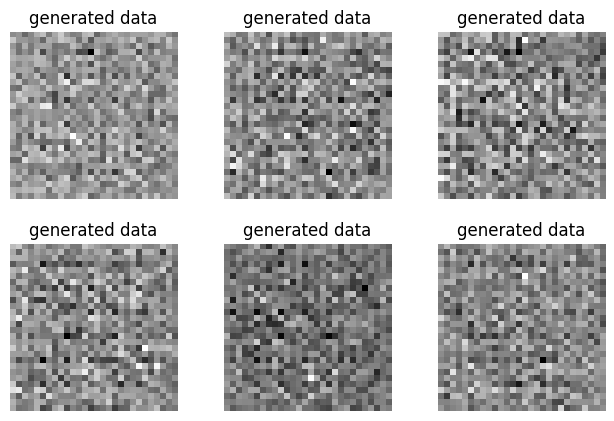

epoch 17


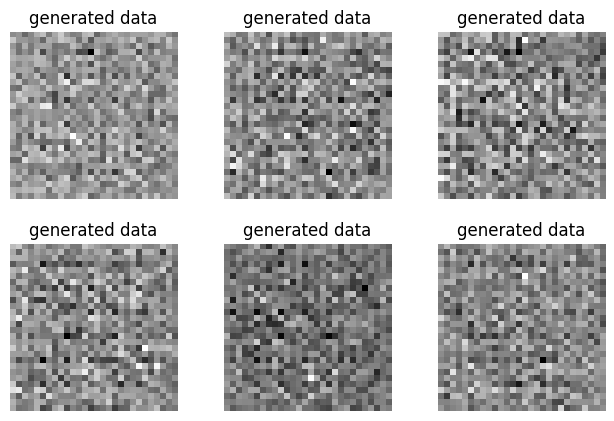

epoch 18


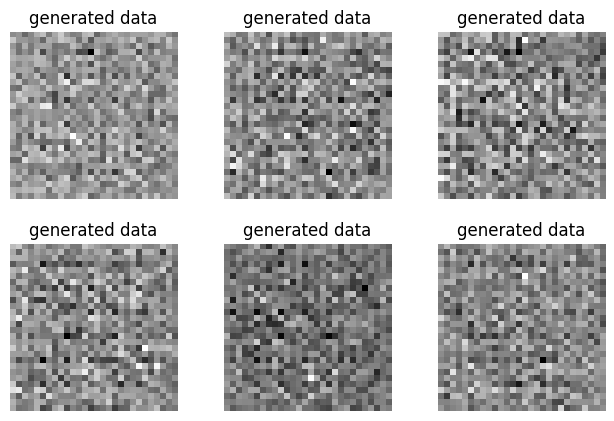

epoch 19


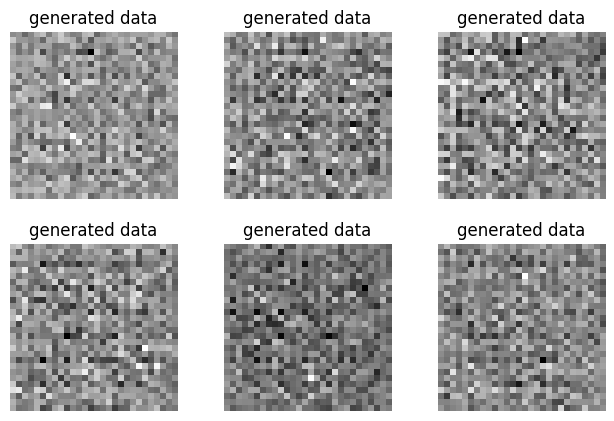

`Trainer.fit` stopped: `max_epochs=20` reached.


In [36]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)